In [1]:
! pip -q install equinox optax

In [2]:
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import optax
import time

from jax import random, vmap
from jax.scipy.fft import dctn
from jax.lax import dot_general, scan
from jax.nn import gelu
from jax.scipy.special import logsumexp
from jax.tree_util import tree_map, tree_flatten

%config InlineBackend.figure_format='retina'

# Vision Transformer

We will use Vision Transformer (ViT) from https://arxiv.org/abs/2010.11929, with two modifications:

1. We will not stack additional classification token
2. At the last layer we process all tokens with linear layer and use them as predictions

The main part of ViT is the encoder from https://arxiv.org/abs/1706.03762 which has the following structure:

\begin{equation}
  \text{normalization} \rightarrow \text{self attention} \rightarrow \text{skip} \rightarrow \text{normalization} \rightarrow \text{shallow MLP} \rightarrow \text{skip}.
\end{equation}

Normalization layer is from https://arxiv.org/abs/1607.06450, MLP and skip connection are both standard. The only nontrivial component is self-attention. It is described below.

Self-attention layer transform sequence of tokens to another sequence of tokens. The end of this process is to improve representation of each token by supplying information from all other tokens in sequence. This is done as follows:
1. Splits the input sequence $x_{i}\in\mathbb{R}^{N_{\text{features}}},\,i=1,\dots,N_{\text{tokens}}$ on key, query, value
\begin{equation}
  \begin{split}
   &k_i = W_{K} x_{i},\\
   &q_i = W_{Q} x_{i},\\
   &v_i = W_{V} x_{i}.\\
  \end{split}
\end{equation}
2. Use key and query to find attention weights
\begin{equation}
  w_{ij} = \exp(q_{i}^{\top} k_{j}) \big/\sum_{j} \exp(q_{i}^{\top} k_{j}).
\end{equation}
3. Form output from value and attention weights
\begin{equation}
  \widetilde{x}_{i} = \sum_{j}w_{ij} v_{j}.
\end{equation}

Self-attention is typically applied with several "attention heads". To add heads one needs:
1. Apply self-attention with $L$ independent $W_{K}, W_{Q}, W_{V}$ to get $\widetilde{x}^{(h)}_{i},\,i=1,\dots, N_{\text{tokens}},\,h=1,\dots, L$.
2. Form output as a linear combination of self-attention outputs $\widetilde{x}_{i} = \sum_{h=1}^{L}A^{(h)} \widetilde{x}^{(h)}_{i}$, where $A^{(h)}$ is the set of additional parameters.

To apply Transformer one need to have a sequence of tokens. The end of tokenizer is to provide this sequence given a set of PDE parameters evaluated on a grid. These parameters are given as a tensor $W\in\mathbb{R}^{N_{x}\times N_{y} \times N_{f}}$, where $N_{f}$ is a number of physical fields. To obtain a sequence we split image on $N\times M$ blocks, where both $N$ and $M$ are hyperparameters ($16$ and $16$ in the original paper). This procedure leave us with $N\times M$ tensors $T_{i}$ of sizes $(N_{x} / N, N_{y} / M, N_{f})$. To obtain tokens we transform this tensors with affine transformation
\begin{equation}
  t_{i} = A\text{vec}(T_{i}) + p_{i},
\end{equation}
where $A$ is a shared learnable linear transformation and $p_{i}$ are learnable positional embeddings.


So, that is it! A high level description of what one needs to do is below:

1. (for simplicity) We want to predict $D=2$ physical field from a set of $D=2$ physical fields.
2. For that we evaluate all fiends on the uniform gird and split this grid in patches.
3. For the input fields we flatten these patches, stack them together for different fields and process with affine transformations with learnable bias (not shared) and linear transformation (shared)
4. After that we feed obtained tokens to encoder of transformer
5. At the end we obtain sequence that we transform with linear layer (all parameters shared; by the way, we can have distinct bias terms here too) such that the output matches the dimension of reshaped chunks of the field we are trying to predict.

In [3]:
def self_attention(tokens, Q, K, V):
    # tokens.shape = (N_features, N_samples), Q.shape = (f_internal, N_features), K.shape = (f_internal, N_features), V.shape = (f_out, N_features), output.shape = (f_out, N_samples)
    q, k, v = Q @ tokens, K @ tokens, V @ tokens
    weights = q.T @ k / jnp.sqrt(q.shape[0])
    weights = jnp.exp(weights - jnp.max(weights, axis=0, keepdims=True))
    tokens = v @ weights / jnp.sum(weights, axis=0, keepdims=True)
    return tokens

def multihead_self_attention(tokens, Q, K, V, M):
    # tokens.shape = (N_features, N_samples), Q.shape = (h, f_internal, N_features), K.shape = (h, f_internal, N_features), V.shape = (h, f_out_1, N_features), M.shape = (h, f_out, f_out_1), output.shape = (f_out, N_samples)
    tokens = vmap(self_attention, in_axes=(None, 0, 0, 0))(tokens, Q, K, V)
    tokens = jnp.sum(dot_general(M, tokens, (((2,), (1,)), ((0,), (0,)))), axis=0)
    return tokens

def normalize_conv(A):
    A = eqx.tree_at(lambda x: x.weight, A, A.weight*jnp.sqrt(2/A.weight.shape[1]))
    A = eqx.tree_at(lambda x: x.bias, A, jnp.zeros_like(A.bias))
    return A

def compute_loss(model, tokens, targets):
    outputs = vmap(model)(tokens)
    loss = jnp.mean(jnp.linalg.norm((outputs - targets).reshape(outputs.shape[0], -1), axis=1))
    return loss

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

def make_step_scan(carry, ind, optim):
    features, targets, model, opt_state = carry
    loss, grads = compute_loss_and_grads(model, features[ind], targets[ind])
    grads = tree_map(jnp.conj, grads)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return [features, targets, model, opt_state], loss

def compute_relative_error(carry, ind):
    features, targets, model = carry
    outputs = vmap(model)(features[ind])
    relative_error = jnp.linalg.norm((outputs - targets[ind]).reshape(outputs.shape[0], -1), axis=1) / jnp.linalg.norm(targets[ind].reshape(outputs.shape[0], -1), axis=1)
    return [features, targets, model], relative_error

class MHSA_block(eqx.Module):
    Q: jnp.array
    K: jnp.array
    V: jnp.array
    M: jnp.array
    layer_norms: list
    MLP: list

    def __init__(self, key, N_features, N_similarity, N_inner, N_head, N_MLP):
        keys = random.split(key, 5)
        norm_factor = jnp.sqrt(2/N_features)
        self.Q = random.normal(keys[0], (N_head, N_similarity, N_features)) * norm_factor
        self.K = random.normal(keys[1], (N_head, N_similarity, N_features)) * norm_factor
        self.V = random.normal(keys[2], (N_head, N_features, N_features)) * norm_factor
        self.M = random.normal(keys[3], (N_head, N_features, N_features)) * norm_factor
        keys = random.split(keys[4], N_MLP)
        self.MLP = [normalize_conv(eqx.nn.Conv(1, N_features, N_features, 1, key=key)) for key in keys]
        self.layer_norms = [eqx.nn.LayerNorm((N_features,)), eqx.nn.LayerNorm((N_features,))]

    def __call__(self, tokens):
        tokens = tokens + multihead_self_attention(vmap(self.layer_norms[0], in_axes=1, out_axes=1)(tokens), self.Q, self.K, self.V, self.M)
        tokens_ = vmap(self.layer_norms[1], in_axes=1, out_axes=1)(tokens)
        for conv in self.MLP:
            tokens_ = gelu(conv(tokens_))
        tokens = tokens + tokens_
        return tokens

class ViT(eqx.Module):
    po_M: jnp.array
    po_v: jnp.array
    MHSA_blocks: list
    decoder: eqx.Module

    def __init__(self, key, N_features, N_head, N_MLP, N_blocks, length):
        keys = random.split(key, N_blocks+2)
        self.po_M = random.normal(keys[0], (N_features[1], N_features[0])) * jnp.sqrt(2/N_features[0])
        self.po_v = jnp.zeros((N_features[1], length))
        self.decoder = normalize_conv(eqx.nn.Conv(1, N_features[1], N_features[2], 1, key=keys[1]))
        self.MHSA_blocks = [MHSA_block(key, N_features[1], N_features[1], N_features[1], N_head, N_MLP) for key in keys[2:]]

    def __call__(self, tokens):
        N, M = jnp.sqrt(tokens.shape[0]).astype(int), jnp.sqrt(tokens.shape[1]).astype(int)
        tokens = self.po_M @ tokens + self.po_v
        for a_block in self.MHSA_blocks:
            tokens = a_block(tokens)
        tokens = self.decoder(tokens)
        return tokens

# KdV D=1+1

In [4]:
def s(x, t, c):
    return c/jnp.cosh(jnp.sqrt(c)*((x-c*t)%1.0-0.5)/2)**2/2

def get_dataset_KdV_2D(key=random.PRNGKey(11), N_samples=1000, c_min=500, c_max=900, delta_t=0.3*1/700, N_x=100, N_t=100, normalize=False):
    x = jnp.linspace(0, 1, N_x)
    keys = random.split(key)
    c = c_min + (c_max - c_min) * random.uniform(keys[0], (N_samples,))
    x0 = random.uniform(keys[1], (N_samples,))
    t0 = x0 / c
    t = delta_t * jnp.linspace(0, 1, N_t)
    X, T = jnp.meshgrid(x, t)
    coordinates = jnp.stack([X, T], 0)
    t = jnp.expand_dims(t, 0) + jnp.expand_dims(t0, 1)
    t = jnp.expand_dims(t, 2)
    x = jnp.expand_dims(x, 0)
    solutions = vmap(s, in_axes=(None, 0, 0))(x, t, c) # solutions.shape = (N_samples, N_t, N_x)

    features = solutions[:, :1, :]
    targets = jnp.expand_dims(solutions, 1)

    if normalize:
        features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
        targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2, 3], keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale

    return features, targets, coordinates

dataset generation time: 1.75706 s
Model size: 673450
Trainig time: 140.55304169654846
Train relative error 0.02204832434654236
Test relative error 0.022473029792308807


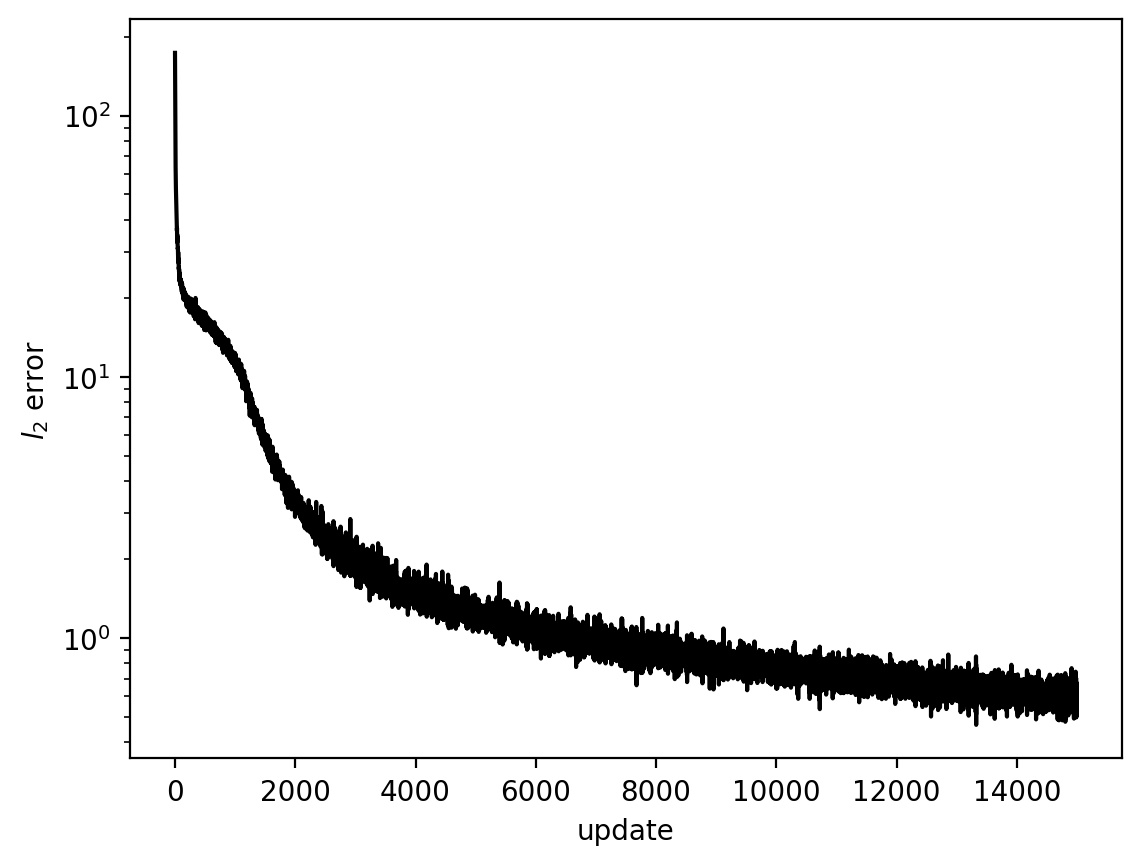

In [5]:
# generate dataset
N_samples = 1000
key = random.PRNGKey(11)
start = time.time()
features, targets, coordinates = get_dataset_KdV_2D(key=key, N_samples=N_samples, normalize=True)
stop = time.time()
print("dataset generation time:", round(stop - start, ndigits=5), "s")

# ViT preprocessing
N_chunks = 5
N_f = targets.shape[-1] // N_chunks
n_f = features.shape[1]

# u_0(x) -> u_0(x, t) = u_0(x)
features = jnp.expand_dims(features, 2) + jnp.zeros_like(targets)
targets = targets[:, 0]

# N_chunks x N_chunks blocks
features = jnp.transpose(features.reshape(-1, n_f, N_f, N_chunks, N_f, N_chunks, order="F"), [0, 1, 2, 4, 3, 5])
features = features.reshape(-1, n_f*N_f*N_f, N_chunks*N_chunks)

targets = jnp.transpose(targets.reshape(-1, N_f, N_chunks, N_f, N_chunks, order="F"), [0, 1, 3, 2, 4])
targets = targets.reshape(-1, N_f*N_f, N_chunks*N_chunks)

# define model
N_features = [features.shape[1], 50, targets.shape[1]]
N_head = 10
N_MLP = 2
N_blocks = 6
length = N_chunks*N_chunks
N_updates = 15000
N_batch = 50
N_train = 800
learning_rate = 1e-4
key = random.PRNGKey(11)

keys = random.split(key, 3)
model = ViT(keys[0], N_features, N_head, N_MLP, N_blocks, length)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0]))
print(f"Model size: {model_size}")

# define optimizer
inds = random.choice(keys[1], N_train, (N_updates, N_batch))
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))
carry = [features, targets, model, opt_state]
make_step_scan_ = lambda a, b: make_step_scan(a, b, optim)

start = time.time()
carry, history = scan(make_step_scan_, carry, inds)
model = carry[2]
stop = time.time()
print(f"Trainig time: {stop - start}")

plt.yscale("log")
plt.plot(history, color="black")
plt.xlabel("update")
plt.ylabel("$l_2$ error")

inds = jnp.arange(features.shape[0])
_, relative_error = scan(compute_relative_error, [features, targets, model], inds.reshape(-1, N_batch))
relative_error = relative_error.reshape(-1,)
train_relative_error = jnp.mean(relative_error[:N_train])
test_relative_error = jnp.mean(relative_error[N_train:])

print(f"Train relative error {train_relative_error}")
print(f"Test relative error {test_relative_error}")

# Burgers D=1+1

Shapes of features, targets and coordinates: (1000, 1, 100) (1000, 1, 100, 100) (2, 100, 100)
Model size: 673450
Trainig time: 137.83250665664673
Train relative error 0.09108053147792816
Test relative error 0.25995883345603943


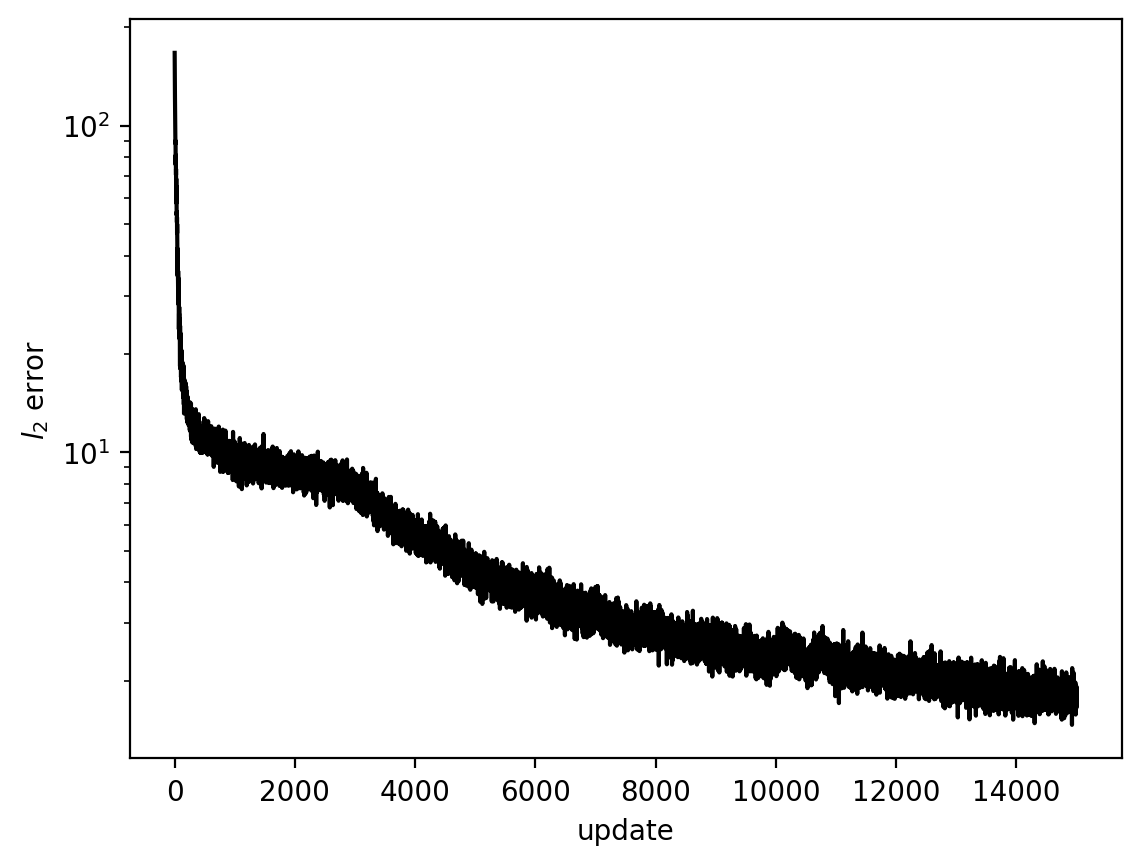

In [6]:
# # download dataset
# # in case this code fails, download using the link and upload to colab / mount your google drive
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/kkcRqJYIIkRUgw' # public link

# final_url = base_url + urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']

# download_response = requests.get(download_url)
# with open('Burgers.npz', 'wb') as f:
#     f.write(download_response.content)

data = jnp.load('Burgers.npz')
features, targets, coordinates = data["features"], data["targets"], data["coordinates"]

features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2, 3], keepdims=True)
features = features / features_scale
targets = targets / targets_scale

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# ViT preprocessing
N_chunks = 5
N_f = targets.shape[-1] // N_chunks
n_f = features.shape[1]

# u_0(x) -> u_0(x, t) = u_0(x)
features = jnp.expand_dims(features, 2) + jnp.zeros_like(targets)
targets = targets[:, 0]

# N_chunks x N_chunks blocks
features = jnp.transpose(features.reshape(-1, n_f, N_f, N_chunks, N_f, N_chunks, order="F"), [0, 1, 2, 4, 3, 5])
features = features.reshape(-1, n_f*N_f*N_f, N_chunks*N_chunks)

targets = jnp.transpose(targets.reshape(-1, N_f, N_chunks, N_f, N_chunks, order="F"), [0, 1, 3, 2, 4])
targets = targets.reshape(-1, N_f*N_f, N_chunks*N_chunks)

# define model
N_features = [features.shape[1], 50, targets.shape[1]]
N_head = 10
N_MLP = 2
N_blocks = 6
length = N_chunks*N_chunks
N_updates = 15000
N_batch = 50
N_train = 800
learning_rate = 1e-4
key = random.PRNGKey(11)

keys = random.split(key, 3)
model = ViT(keys[0], N_features, N_head, N_MLP, N_blocks, length)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0]))
print(f"Model size: {model_size}")

# define optimizer
inds = random.choice(keys[1], N_train, (N_updates, N_batch))
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))
carry = [features, targets, model, opt_state]
make_step_scan_ = lambda a, b: make_step_scan(a, b, optim)

start = time.time()
carry, history = scan(make_step_scan_, carry, inds)
model = carry[2]
stop = time.time()
print(f"Trainig time: {stop - start}")

plt.yscale("log")
plt.plot(history, color="black")
plt.xlabel("update")
plt.ylabel("$l_2$ error")

inds = jnp.arange(features.shape[0])
_, relative_error = scan(compute_relative_error, [features, targets, model], inds.reshape(-1, N_batch))
relative_error = relative_error.reshape(-1,)
train_relative_error = jnp.mean(relative_error[:N_train])
test_relative_error = jnp.mean(relative_error[N_train:])

print(f"Train relative error {train_relative_error}")
print(f"Test relative error {test_relative_error}")

# Elliptic D=2

Shapes of features, targets and coordinates: (1000, 2, 64, 64) (1000, 1, 64, 64) (2, 64, 64)
Model size: 671256
Trainig time: 95.03329825401306
Train relative error 0.10833214223384857
Test relative error 0.1171114593744278


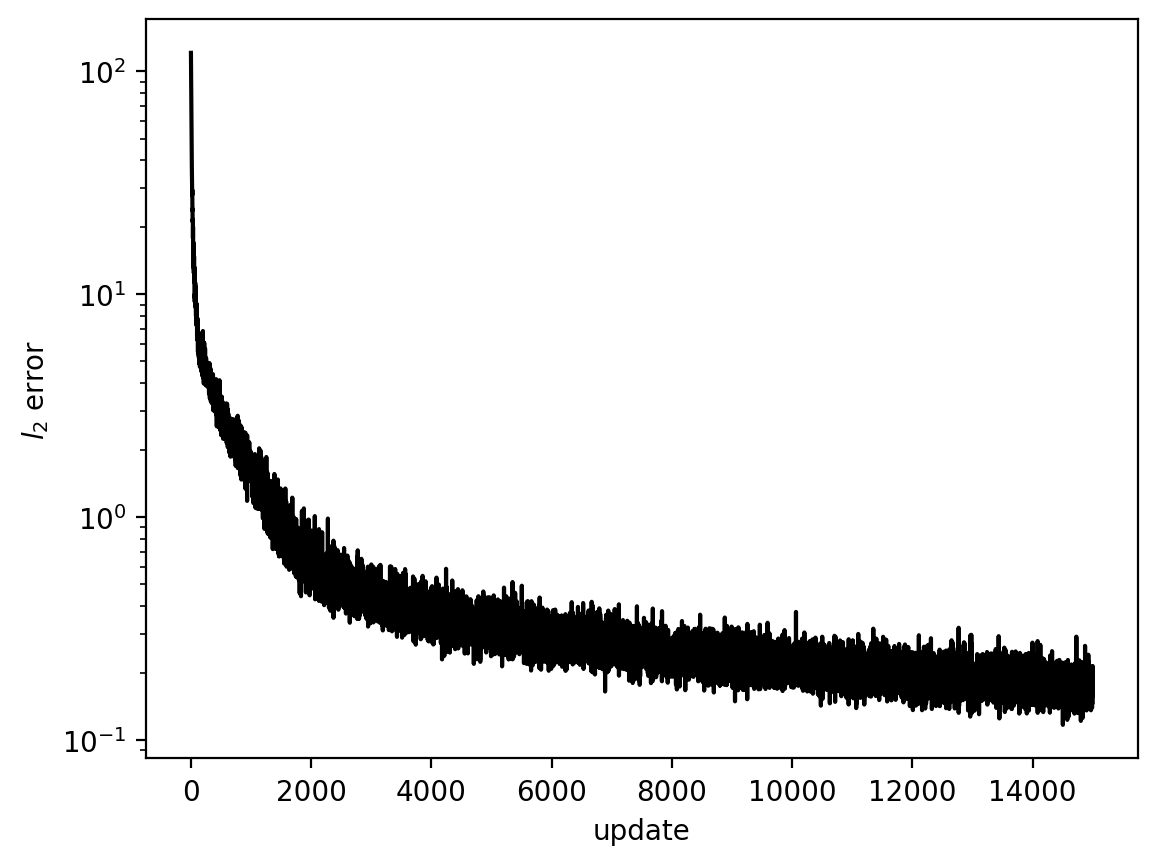

In [7]:
# # download dataset
# # in case this code fails, download using the link and upload to colab / mount your google drive
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/fz9ghnFEDm90Qw' # public link

# final_url = base_url + urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']

# download_response = requests.get(download_url)
# with open('Elliptic.npz', 'wb') as f:
#     f.write(download_response.content)

data = jnp.load('Elliptic.npz')
features, targets, coordinates = data["features"], data["targets"], data["coordinates"]

features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2, 3], keepdims=True)
features = features / features_scale
targets = targets / targets_scale

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# ViT preprocessing
N_chunks = 4
N_f = targets.shape[-1] // N_chunks
n_f = features.shape[1]

targets = targets[:, 0]

# N_chunks x N_chunks blocks
features = jnp.transpose(features.reshape(-1, n_f, N_f, N_chunks, N_f, N_chunks, order="F"), [0, 1, 2, 4, 3, 5])
features = features.reshape(-1, n_f*N_f*N_f, N_chunks*N_chunks)

targets = jnp.transpose(targets.reshape(-1, N_f, N_chunks, N_f, N_chunks, order="F"), [0, 1, 3, 2, 4])
targets = targets.reshape(-1, N_f*N_f, N_chunks*N_chunks)

# define model
N_features = [features.shape[1], 50, targets.shape[1]]
N_head = 10
N_MLP = 2
N_blocks = 6
length = N_chunks*N_chunks
N_updates = 15000
N_batch = 50
N_train = 800
learning_rate = 1e-4
key = random.PRNGKey(11)

keys = random.split(key, 3)
model = ViT(keys[0], N_features, N_head, N_MLP, N_blocks, length)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0]))
print(f"Model size: {model_size}")

# define optimizer
inds = random.choice(keys[1], N_train, (N_updates, N_batch))
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))
carry = [features, targets, model, opt_state]
make_step_scan_ = lambda a, b: make_step_scan(a, b, optim)

start = time.time()
carry, history = scan(make_step_scan_, carry, inds)
model = carry[2]
stop = time.time()
print(f"Trainig time: {stop - start}")

plt.yscale("log")
plt.plot(history, color="black")
plt.xlabel("update")
plt.ylabel("$l_2$ error")

inds = jnp.arange(features.shape[0])
_, relative_error = scan(compute_relative_error, [features, targets, model], inds.reshape(-1, N_batch))
relative_error = relative_error.reshape(-1,)
train_relative_error = jnp.mean(relative_error[:N_train])
test_relative_error = jnp.mean(relative_error[N_train:])

print(f"Train relative error {train_relative_error}")
print(f"Test relative error {test_relative_error}")